Creating ReplayPhenotype and Fitness objects

In [1]:
from gcdyn.fitness import Fitness
from gcdyn.replay import ReplayPhenotype
import gcdyn.replay as replay

In [6]:
replay_phenotype = ReplayPhenotype(
    1,
    1,
    336,
    "https://raw.githubusercontent.com/jbloomlab/Ab-CGGnaive_DMS/main/data/CGGnaive_sites.csv",
    "Linear.model",
    ["delta_log10_KD", "expression"],
    -10.43,
)


fasta_path = "gcreplay_samples/gctree_PR1.3-1-LB-16-GC.fasta"
seqs = replay.fasta_to_seq_list(fasta_path)

fit = Fitness(Fitness.sigmoidal_fitness)
fitness_df = fit.normalized_fitness_df(seqs, calculate_KD=replay_phenotype.calculate_KD)

,seq,KD,frac_antigen_bound,t_cell_help,normalized_t_cell_help
0,GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTC...,7.160184e-11,0.933182,3.948108,0.020207
1,GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTC...,2.146424e-09,0.317821,0.556877,0.002850
2,GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTC...,1.207058e-11,0.988073,3.969863,0.020318
3,GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTC...,3.184563e-09,0.238974,0.273923,0.001402
4,GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTC...,2.221563e-10,0.818226,3.840645,0.019657
5,GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTC...,2.301015e-09,0.302937,0.489286,0.002504
6,GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTC...,4.299284e-10,0.699336,3.520391,0.018018
7,GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTC...,6.115571e-09,0.140537,0.106945,0.000547
8,GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTC...,7.802672e-10,0.561713,2.598266,0.013298
9,GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTC...,4.384221e-10,0.695206,3.502685,0.017927


Testing different antigen concentrations vs antigen bound

/Users/alyssa/miniconda3/envs/gcdyn_39/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/alyssa/miniconda3/envs/gcdyn_39/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_histogram : Removed 10 rows containing missing values.


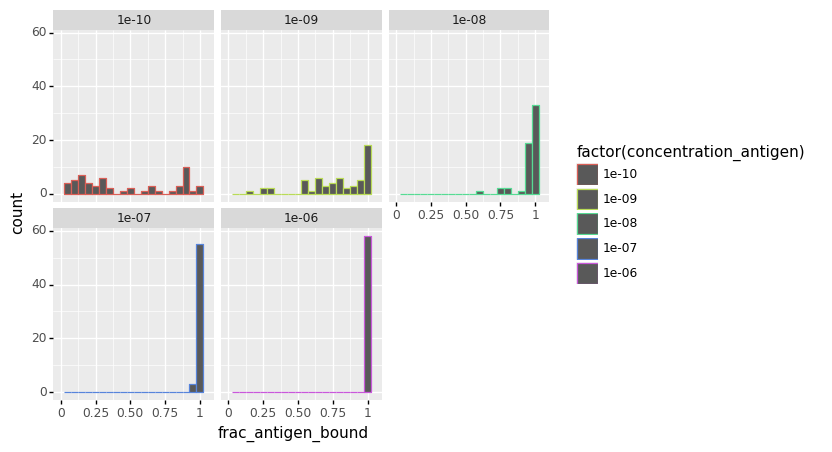

<ggplot: (8766553537720)>

In [3]:
import pandas as pd
from plotnine import ggplot, geom_histogram, aes, facet_wrap, ggtitle, xlim, ylim

antigen_bound_fracs = []
concentrations = []
for c in range(6, 11):  # concentration of antigen from 10^-6 to 10^-10
    concentration_antigen = 10 ** (-1 * c)
    fit = Fitness(Fitness.sigmoidal_fitness, concentration_antigen)
    antigen_bound_fracs.extend(fit.frac_antigen_bound(fitness_df["KD"]))
    concentrations.extend([concentration_antigen] * len(fitness_df["KD"]))

antigen_bound_df = pd.DataFrame(
    {"concentration_antigen": concentrations, "frac_antigen_bound": antigen_bound_fracs}
)
antigen_bound_df

(
    ggplot(antigen_bound_df)
    + facet_wrap(facets="~concentration_antigen")
    + aes(x="frac_antigen_bound", color="factor(concentration_antigen)")
    + geom_histogram(binwidth=0.05)
    + xlim(0, 1.05)
)

Mapping to fitness (sigmoidal)

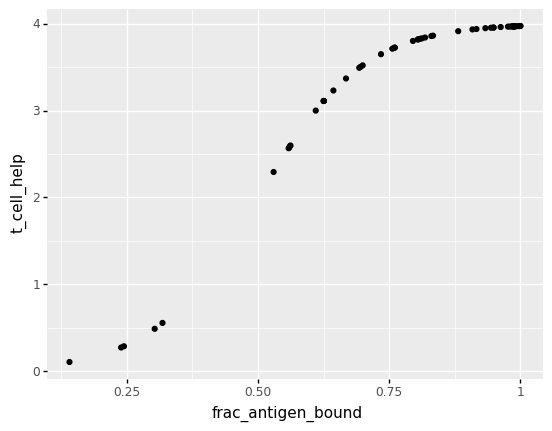

<ggplot: (8766555113463)>

In [5]:
from plotnine import geom_point

ggplot(fitness_df) + aes(x="frac_antigen_bound", y="t_cell_help") + geom_point()

Normalized fitness (T cell help)

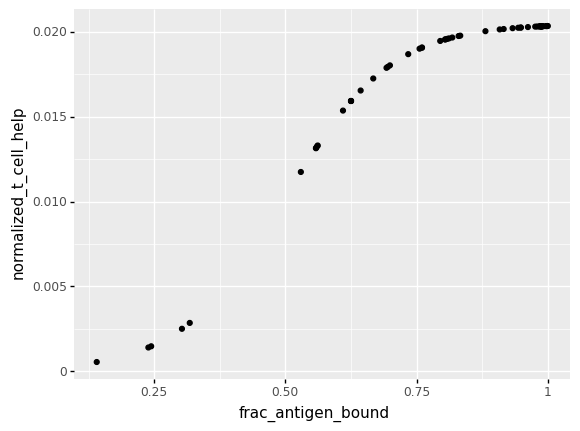

<ggplot: (8765435661331)>

In [5]:
(
    ggplot(fitness_df)
    + aes(x="frac_antigen_bound", y="normalized_t_cell_help")
    + geom_point()
)

Map to fitness (linear)

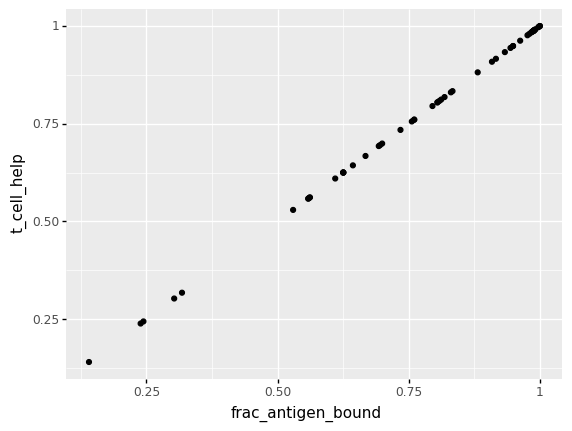

<ggplot: (8765435709931)>

In [6]:
linfit = Fitness(Fitness.linear_fitness)
linfit_fitness_df = linfit.normalized_fitness_df(
    seqs, calculate_KD=replay_phenotype.calculate_KD
)
ggplot(linfit_fitness_df) + aes(x="frac_antigen_bound", y="t_cell_help") + geom_point()

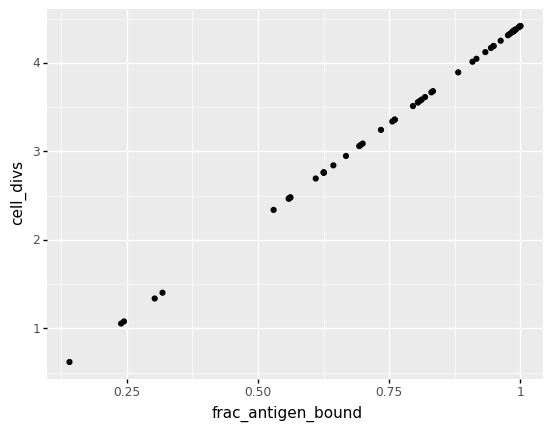

<ggplot: (8765435676700)>

In [7]:
# map normalized fitness linearly to number of cell divisions
test_cell_divs = linfit.cell_divisions_from_tfh_linear(linfit_fitness_df, 200)
linfit_fitness_df["cell_divs"] = test_cell_divs
ggplot(linfit_fitness_df) + aes(x="frac_antigen_bound", y="cell_divs") + geom_point()

Uniform fitness

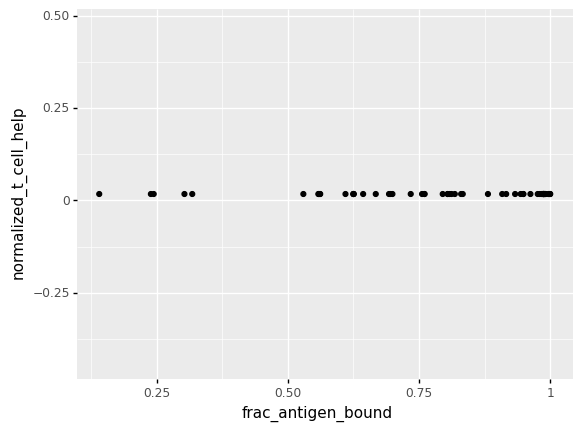

<ggplot: (8765435467608)>

In [10]:
uniform_fit = Fitness(Fitness.uniform_fitness)
uniform_fitness_df = uniform_fit.normalized_fitness_df(
    seqs, calculate_KD=replay_phenotype.calculate_KD
)
uniform_fitness_df["frac_antigen_bound"] = uniform_fit.frac_antigen_bound(
    uniform_fitness_df["KD"]
)
(
    ggplot(uniform_fitness_df)
    + aes(x="frac_antigen_bound", y="normalized_t_cell_help")
    + geom_point()
)